# Out-of-distribution

* [You can run this example on Google Colab.](https://colab.research.google.com/github/seungjin-yang/extended-tensorflow-probability/blob/master/examples/notebooks/out-of-distribution.ipynb)
* Runtime > Runtime> Change runtime type > Hardware accelerator > GPU

In [ ]:
%%bash
python -c "import google.colab"
if [[ $? == "0" ]]
then
    echo "Hello, Colab!"
    pip install tensorflow-gpu==2.0.0-rc1
    pip install tensorflow-probability==0.8.0-rc0
    pip install git+https://github.com/seungjin-yang/extended-tensorflow-probability
fi

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp

import extended_tfp as extfp

tfd = tfp.distributions
tfpl = tfp.layers

### Version

In [2]:
assert tf.version.VERSION in ['2.0.0-rc1', '2.0.0-rc2', '2.0.0']
assert tfp.__version__ == '0.8.0-rc0'

### Keras

In [3]:
K.set_image_data_format('channels_first')

# Dataset - MNIST

In [4]:
def transform_image(x):
    x = x[:, np.newaxis]
    x = x.astype(np.float32)
    x /= 255
    return x

In [5]:
def visualize_mnist(x, num_cols=5, image_size=2):
    x = x.squeeze()
    rank = len(x.shape)
    if rank == 2:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(x)
        ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    if rank == 3:
        num_images = len(x)
        num_rows = np.ceil(num_images / num_cols).astype(int)
        figsize = (image_size * num_cols, image_size * num_rows)
        fig, axarr = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
        for img, ax in zip(x, axarr.flatten()):
            ax.imshow(img)
            ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data('/tmp/mnist.npz')

x_train = transform_image(x_train)
x_test = transform_image(x_test)

x_valid = x_train[-10000:]
x_train = x_train[:-10000]

y_valid = y_train[-10000:]
y_train = y_train[:-10000]

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

input_shape = x_train.shape[1:]
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

(50000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)


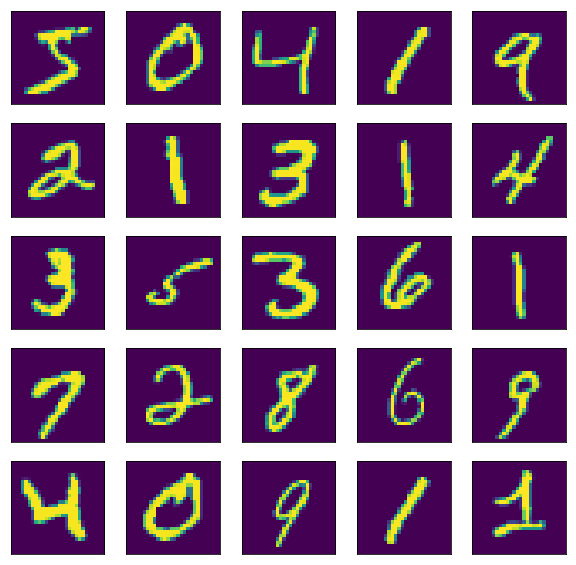

In [7]:
visualize_mnist(x_train[:25])

# Model Building

In [8]:
kl_weight = 1 / len(x_train)
print('KL weight: {}'.format(kl_weight))

KL weight: 2e-05


### Theory



* $\large p(y=d|\mathbf{x},\omega) = \text{Softmax}(\textbf{f}^{\omega}(\mathbf{x}))_{d} \quad \text{(a likelihood distribution)}$

* $\large p(\omega|\mathcal{D}) \qquad \text{(the interactable true posterior)}$

* $\large q_{\theta}(\omega|\mathcal{D}) \qquad \text{(the variational posterior)}$



<br/>


### Codes
```python
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
  ])

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
    ])
```

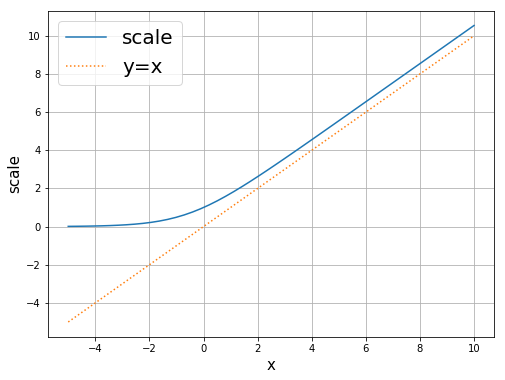

In [9]:
c = np.log(np.expm1(1.0))

x_plot = np.linspace(-5, 10)
scale = (1e-5 + tf.nn.softplus(c + x_plot)).numpy()

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, scale, label='scale')
ax.plot(x_plot, x_plot, label='y=x', ls=':')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('scale', fontsize=15)
ax.legend(fontsize=20)
ax.grid()

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    extfp.layers.Conv2DVariational(
        filters=32,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    extfp.layers.Conv2DVariational(
        filters=64,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tfp.layers.DenseVariational(
        units=128,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    tfp.layers.DenseVariational(
        units=10,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tfpl.OneHotCategorical(num_classes),
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_variational (Conv2DVa (None, 32, 24, 24)        2496      
_________________________________________________________________
activation (Activation)      (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_variational_1 (Conv2D (None, 64, 20, 20)        153792    
_________________________________________________________________
activation_1 (Activation)    (None, 64, 20, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 6)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense_variational (DenseVari (None, 128)               2

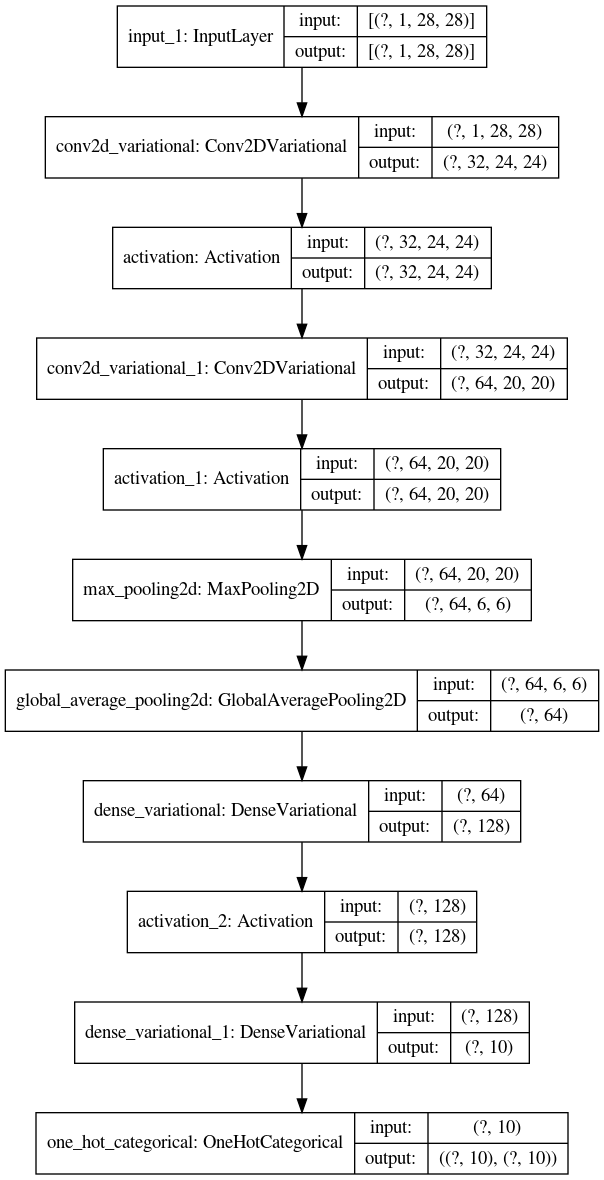

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='/tmp/model.png')

# Training

### Theory
$$
\large \mathcal{L}_{VI}(\theta) := -\frac{N}{M}\sum_{i \in S} \int q_{\theta}(\omega) \log p(\mathbf{y}_{i}|\textbf{f}^{\omega}(\mathbf{x}_{i})) \text{d} \omega + \text{KL}(q_{\theta}(\omega)||p(\omega))
$$
with a random index set $S$ of size $M$.



### Codes
```python
def negative_log_likelihood(y_true, y_pred_distribution):
    return -y_pred_distribution.log_prob(y_true)


def kl_divergence_fn(distribution_a, distribution_b):
    z = test_points_fn(distribution_a)
    return tf.reduce_mean(
        input_tensor=distribution_a.log_prob(z) - distribution_b.log_prob(z),
        axis=test_points_reduce_axis)
```

You can find out [more about the implementation of KL divergence.](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/dense_variational_v2.py#L159-L163)

In [13]:
model.compile(loss=extfp.losses.negative_log_likelihood,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

In [14]:
# TODO how to save model with variational layers
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)
]

In [15]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=500,
          shuffle=True,
          verbose=2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
50000/50000 - 7s - loss: 262.4311 - accuracy: 0.1061 - val_loss: 2.6573 - val_accuracy: 0.1059
Epoch 2/500
50000/50000 - 3s - loss: 2.5313 - accuracy: 0.1112 - val_loss: 2.4817 - val_accuracy: 0.1182
Epoch 3/500
50000/50000 - 4s - loss: 2.4332 - accuracy: 0.1300 - val_loss: 2.3439 - val_accuracy: 0.1333
Epoch 4/500
50000/50000 - 3s - loss: 2.4048 - accuracy: 0.1550 - val_loss: 2.2658 - val_accuracy: 0.1547
Epoch 5/500
50000/50000 - 3s - loss: 2.3009 - accuracy: 0.1738 - val_loss: 2.2382 - val_accuracy: 0.1713
Epoch 6/500
50000/50000 - 3s - loss: 2.2095 - accuracy: 0.1866 - val_loss: 2.2156 - val_accuracy: 0.1725
Epoch 7/500
50000/50000 - 3s - loss: 2.2201 - accuracy: 0.1908 - val_loss: 2.2234 - val_accuracy: 0.1580
Epoch 8/500
50000/50000 - 3s - loss: 2.1722 - accuracy: 0.1926 - val_loss: 2.1518 - val_accuracy: 0.1975
Epoch 9/500
50000/50000 - 3s - loss: 2.1376 - accuracy: 0.1994 - val_loss: 2.1291 - val_accuracy: 0.2093
Epo

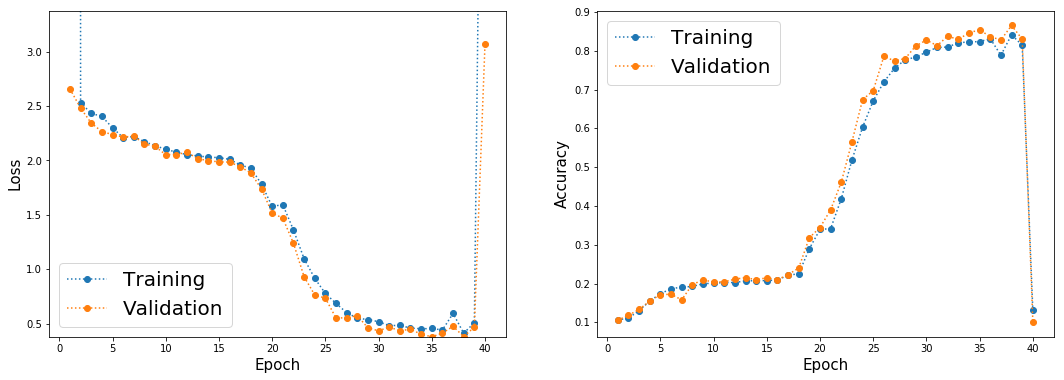

In [38]:
fig, axarr = plt.subplots(ncols=2, figsize=(18, 6))

epoch = list(range(1, len(history.history['loss']) + 1))

plot_kwargs = {
    'ls': ':',
    'marker': 'o'
}

val_loss = history.history['val_loss']

axarr[0].plot(epoch, history.history['loss'], label='Training', **plot_kwargs)
axarr[0].plot(epoch, val_loss, label='Validation', **plot_kwargs)
axarr[0].set_xlabel('Epoch', fontsize=15)
axarr[0].set_ylabel('Loss', fontsize=15)
axarr[0].set_ylim(min(val_loss), 1.1 * max(val_loss))
axarr[0].legend(fontsize=20)


axarr[1].plot(epoch, history.history['accuracy'], label='Training', **plot_kwargs)
axarr[1].plot(epoch, history.history['val_accuracy'], label='Validation', **plot_kwargs)
axarr[1].set_xlabel('Epoch', fontsize=15)
axarr[1].set_ylabel('Accuracy', fontsize=15)
axarr[1].legend(fontsize=20)

# Evaluation

In [18]:
def sample_prediction(model, x, num_monte_carlo=100):
    assert isinstance(model.layers[-1], tfpl.OneHotCategorical)
    y_dist = model(x)
    y_samples = y_dist.sample(num_monte_carlo)
    return tf.argmax(tf.reduce_sum(y_samples, axis=0), axis=1)

In [26]:
y_pred_test = sample_prediction(model, x_test, num_monte_carlo=1000)
accuracy = (y_pred_test.numpy() == y_test.argmax(axis=1)).mean()
print('Accuracy: {:.2f} %'.format(accuracy * 100))

Accuracy: 90.18 %


# Out-of-distribution


* Aleatoric
    * homoscedastic
    * heteroscedastic
* Epistemic

In [27]:
_, (x_fashion, y_fashion) = tf.keras.datasets.fashion_mnist.load_data()
x_fashion = transform_image(x_fashion)

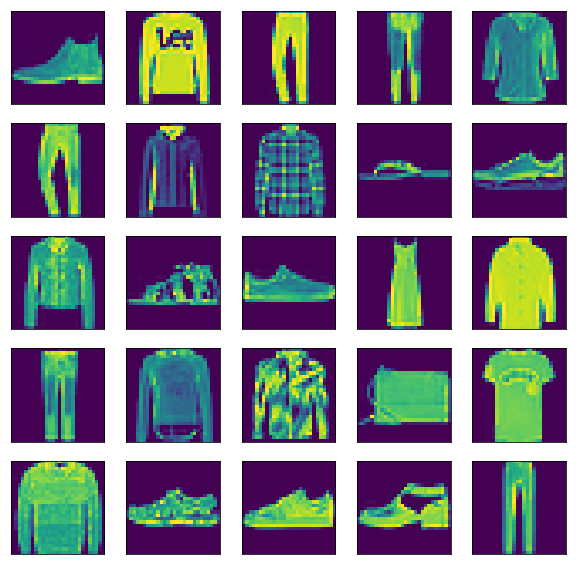

In [28]:
visualize_mnist(x_fashion[:25])

In [29]:
def sample_probability(model, data, num_samples):
    assert isinstance(model.layers[-1], tfpl.OneHotCategorical)
    samples = [model.predict_on_batch(data).probs_parameter() for _ in range(num_samples)]
    return tf.stack(samples)

In [30]:
y_test_samples = sample_probability(model, x_test, num_samples=100)
y_fashion_samples = sample_probability(model, x_fashion, num_samples=100)

In [31]:
def plot_uncertainty(uncertainty, uncertainty_ood, xlabel, bins=200, log_y=False):
    def to_numpy(arg):
        if isinstance(arg, np.ndarray):
            return arg
        elif isinstance(arg, tf.Tensor):
            return arg.numpy()
        else:
            raise TypeError
    uncertainty = to_numpy(uncertainty)
    uncertainty_ood = to_numpy(uncertainty_ood)
        
    
    x_max = max(max(uncertainty), max(uncertainty_ood))
    x_range = (0, x_max)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(uncertainty, alpha=0.5, range=x_range, bins=bins, label='MNIST')
    ax.hist(uncertainty_ood, alpha=0.5, range=x_range, bins=bins, label='Fashion MNIST (OOD)')
    ax.legend(fontsize=20)
    ax.set_xlabel(xlabel, fontsize=15)
    
    if log_y:
        ax.set_yscale('log')

## Variational-Ratio

### Theory
* $\large \text{variation-ratio}[\mathbf{x}] := 1 - \frac{f_{\mathbf{x}}}{T}$
* $\large c^{*} = \underset{c=1,\ldots,C}{\text{argmax}} \sum_{t}\mathbb{1}[y^{t}=c]$
* $\large f_{\mathbf{x}} = \sum_{t} \mathbb{1}[y^{t}=c^{*}]$


### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L5-L20)
```python
def compute_variation_ratio(prob_samples):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    num_samples = len(prob_samples)
    mode = tf.reduce_max(prob_samples, axis=2, keepdims=True)
    is_mode = tf.dtypes.cast(prob_samples == mode, prob_samples.dtype)
    num_mode = tf.reduce_sum(is_mode, axis=2, keepdims=True)
    mode_frequency = tf.reduce_max(tf.reduce_sum(is_mode / num_mode, axis=0), axis=1)
    return 1 - (mode_frequency / num_samples)
```

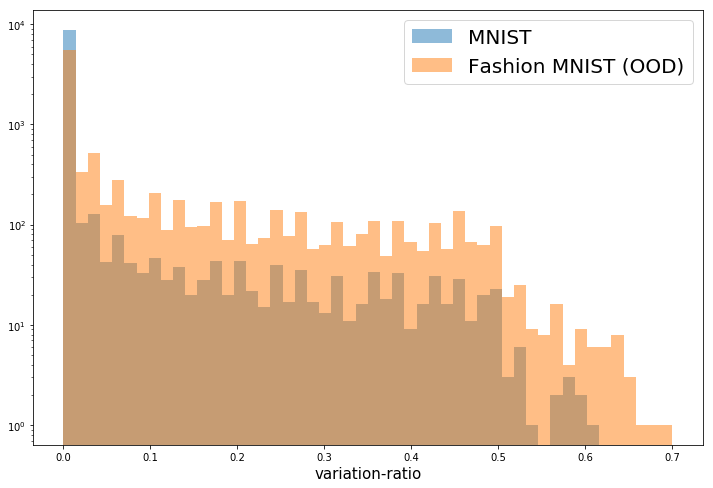

In [32]:
variation_ratio_test = extfp.uncertainty.compute_variation_ratio(y_test_samples)
variation_ratio_fashion = extfp.uncertainty.compute_variation_ratio(y_fashion_samples)
plot_uncertainty(variation_ratio_test, variation_ratio_fashion, 'variation-ratio', bins=50, log_y=True)

# Predictive Entropy

### Theory
* $\large \mathbb{H}[y|\mathbf{x},\mathcal{D}] := -\sum_{c} p(y=c|\mathbf{x},\mathcal{D}_{train}) \log p(y=c|\mathbf{x},\mathcal{D}_{train})$

* $\large [p(y=1|\mathbf{x},\hat{\omega}_{t}) , \ldots , p(y=C|\mathbf{x},\hat{\omega}_{t})] := \text{Softmax}(\textbf{f}^{\hat{\omega}_{t}}(\mathbf{x}))$

* $\large \tilde{\mathbb{H}}[y|\mathbf{x},\mathcal{D}] = - \sum_{c} (\frac{1}{T} \sum_{t}p(y=c|\mathbf{x},\hat{\omega}_{t})) \log (\frac{1}{T} \sum_{t}p(y=c|\mathbf{x},\hat{\omega}_{t}))$

### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L23-L36)
```python
def compute_predictive_entropy(prob_samples, eps=1e-12):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    # predictive probability
    pred_prob = tf.reduce_mean(prob_samples, axis=0)
    pred_log_prob = tf.math.log(tf.clip_by_value(pred_prob, eps, 1))
    return -tf.reduce_sum(pred_prob * pred_log_prob, axis=1)
```

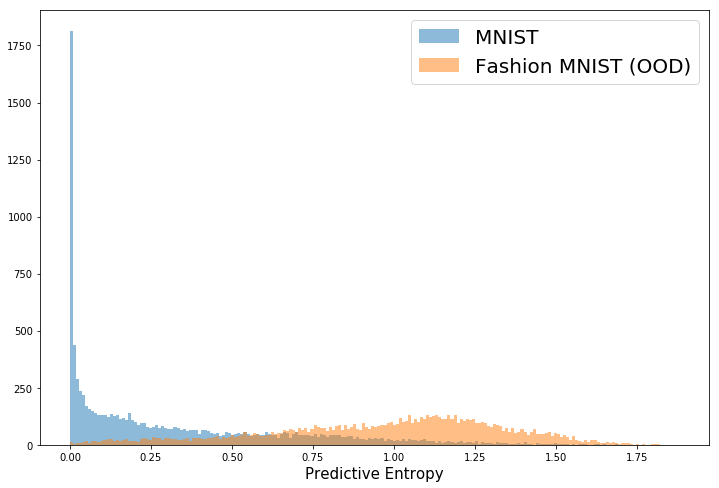

In [33]:
pred_entropy_test = extfp.uncertainty.compute_predictive_entropy(y_test_samples)
pred_entropy_fashion = extfp.uncertainty.compute_predictive_entropy(y_fashion_samples)
plot_uncertainty(pred_entropy_test, pred_entropy_fashion, 'Predictive Entropy')

# Mutual Information

### Theory
* $\large \mathbb{I}[y,\omega|\mathbf{x},\mathcal{D}_{\text{train}}] := \mathbb{H}[y|\mathbf{x},\mathcal{D}_{\text{train}}] - \mathbb{E}_{p(\omega|\mathcal{D}_{\text{train}})}\mathbb{H}[y|\mathbf{x},\omega]$

* $\large \tilde{\mathbb{I}}[y,\omega|\mathbf{x},\mathcal{D}_{\text{train}}] := \tilde{\mathbb{H}}[y|\mathbf{x},\mathcal{D}_\text{train}] + \frac{1}{T} \sum_{c,t} p(y=c|\mathbf{x},\hat{\omega}_{t}) \log p(y=c|\mathbf{x},\hat{\omega}_{t})$

### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L39-L53)
```python
def compute_mutual_information(prob_samples, eps=1e-12):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    predictive_entropy = compute_predictive_entropy(prob_samples)

    log_prob_samples = tf.math.log(tf.clip_by_value(prob_samples, eps, 1))
    neg_entropy_samples = tf.reduce_sum(prob_samples * log_prob_samples, axis=2)
    return predictive_entropy + tf.reduce_mean(neg_entropy_samples, axis=0)
```

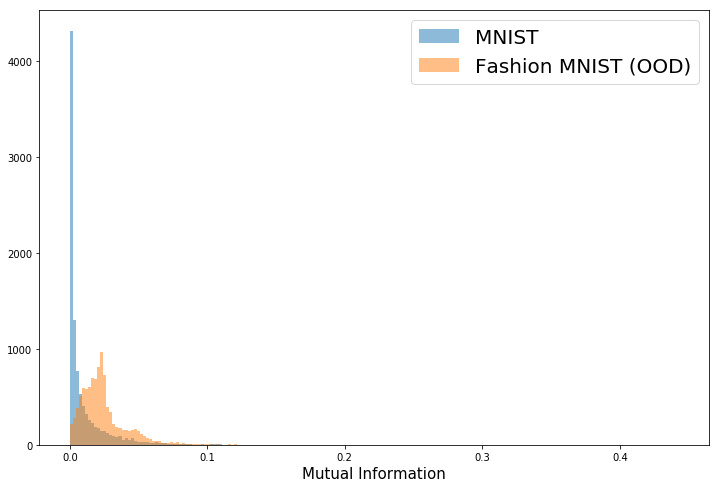

In [36]:
mutual_info_test = extfp.uncertainty.compute_mutual_information(y_test_samples)
mutual_info_fashion = extfp.uncertainty.compute_mutual_information(y_fashion_samples)
plot_uncertainty(mutual_info_test, mutual_info_fashion, 'Mutual Information')